In [0]:
from scipy.optimize import dual_annealing, minimize
from sklearn.metrics import r2_score
from collections import namedtuple
from matplotlib import pyplot as plt
import math


In [0]:
SEIR_PARAM = namedtuple('SEIRparm', ['beta_1', 'beta_2', 'xi', 'sigma', 'gamma_I', 'mu_I'])

class SEIR(object):
    def __init__(self, P=None):
        self.P = P

    def _forward(self, S, E, I, D, R, param, max_iter):
        beta_1, beta_2, xi, sigma, gamma_I, mu_I= param
        est = pd.DataFrame(columns=['S', 'E', 'I', 'D', 'R'])
        N = S+E+I+D+R
        for t in range(max_iter):
            S_ = S - beta_1 *  I - beta_2 * E + xi* R
            E_ = E + beta_1 *  I + beta_2 * E - sigma * E
            I_ = I + sigma*E - gamma_I *I - mu_I *I
            D_ = D + mu_I *I
            R_ = R + gamma_I *I - xi* R
            S, E, I, D, R = S_, E_, I_, D_, R_
            est.loc[t] = [S, E, I, D, R]
        return est

    def _loss(self, obs, est):
        assert len(obs) == len(est)
        loss = np.log((((obs - est) ** 2)**(1/2)).sum()/len(obs)/3)
        self.lossing.append(loss)
        return loss

    def _optimize(self, param, s, e, i, d, c, obs):
        est = self._forward(s, e, i, d, c, param, len(obs))
        return self._loss(obs, np.array(est[['I', 'D', 'R']]))

    def fit(self, initS, initE, initI, initD, initC, Y):
        self.lossing = []
        args = (initS, initE, initI, initD, initC, np.array(Y))
        param = [(0, 1),]*6
        result = dual_annealing(self._optimize, param, args=args, seed=10, maxiter=20)['x']
        self.P = SEIR_PARAM(*result)

    def score(self, initS, initE, initI, initD, initC, Y, plot=False):
        est = self.predict(initS, initE, initI, initD, initC, len(Y))[['I', 'D', 'R']]
        loss = self._loss(np.array(Y[['cases','deaths', 'recovered']]), np.array(est))
        est.columns = ['cases','deaths','recovered']
        r1 = r2_score(Y['cases'], est['cases'])
        r2 = r2_score(Y['deaths'], est['deaths'])
        r3 = r2_score(Y['recovered'], est['recovered'])
        if plot:
            self.plot_predict(Y, est)
            print(' - recoveredR2：%.4f' % r3)
            print(' - deathsR2：%.4f' % r2)
            print(' - casesR2：%.4f' % r1)

            print(' - model R2：%.4f' % ((r1 + r2 + r3) / 3))
            print(' - Loss：%.4f' % loss)
        return loss, (r1 + r2 + r3) / 3
    
    def plot_error(self):
        plt.plot(self.lossing, label=u'error')
        plt.legend()
        plt.show()
    
    def plot_predict(self, obs, est):
        for label in obs.keys():
            plt.plot(obs[label], color= 'b', alpha=0.6, label="real")
            plt.plot(est[label], color= 'r', alpha=0.6, label="forecast")
            plt.legend()
            plt.show()
            
    def predict(self, initS, initE, initI, initD,initC, T):
        return self._forward(initS, initE, initI, initD, initC, self.P, T)
  

In [0]:
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from numpy import array


df_data = pd.read_csv("data.csv")
df_data.drop(columns='Unnamed: 0',axis=1,inplace=True)
df_data=df_data[['cases','deaths','recovered']]
df_data = df_data[0:45]

potential：0.0000 | R2：0.6764 | error： 9.125326
potential：25.0000 | R2：0.6843 | error： 9.091360
potential：50.0000 | R2：0.7042 | error： 9.077579
potential：75.0000 | R2：0.7156 | error： 9.064553
potential：150.0000 | R2：0.7208 | error： 9.023892
potential：175.0000 | R2：0.7289 | error： 9.010257
potential：200.0000 | R2：0.7611 | error： 8.967675
potential：275.0000 | R2：0.7699 | error： 8.951428
potential：300.0000 | R2：0.7712 | error： 8.949031
potential：325.0000 | R2：0.7757 | error： 8.934683
potential：350.0000 | R2：0.7808 | error： 8.930077
potential：400.0000 | R2：0.7910 | error： 8.905825
potential：425.0000 | R2：0.9003 | error： 8.488475
potential：550.0000 | R2：0.9437 | error： 8.239433
potential：675.0000 | R2：0.9747 | error： 7.953605
potential：1000.0000 | R2：0.9797 | error： 7.927266


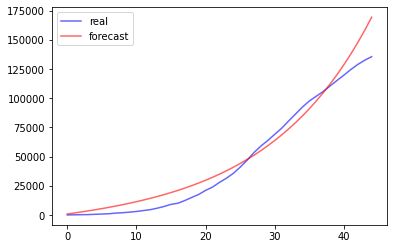

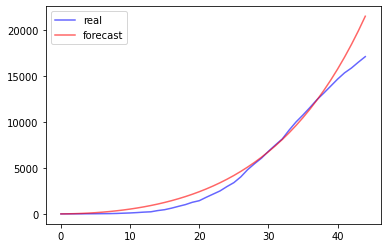

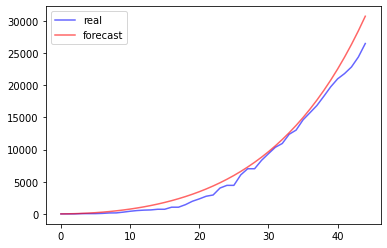

 - recoveredR2：0.9729
 - deathsR2：0.9629
 - casesR2：0.9555
 - model R2：0.9638
 - Loss：8.0285


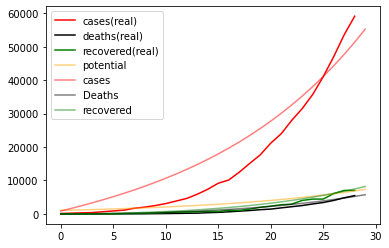

In [11]:
def searchBestParam(seir):
    min_loss, max_r2, best_param, likeli_potential = float('inf'),0.0, None, 0
    for potential in range(0, 1100, 25):
        seir.fit(60000000, potential, 132, 2, 1, df_data)
        loss, r2 = seir.score(60000000, potential, 132, 2, 1, Y=df_data)
        if loss < min_loss and r2 > max_r2:
            print('potential：%.4f | R2：%.4f | error： %.6f' % (potential, r2, loss))
            min_loss, max_r2, best_param, likeli_potential = loss, r2, seir.P, potential
    seir.P = best_param
    seir.score(60000000, potential, 132, 2, 1, df_data, plot=True)
    return seir, likeli_potential

seir, potentials = searchBestParam(SEIR())

def forcast(seir, T):
    predict = seir.predict(60000000, potentials, 132, 2, 1, T)
    plt.plot(df_data[0:29]['cases'], label='cases(real)', color='red')
    plt.plot(df_data[0:29]['deaths'], label='deaths(real)', color='black')
    plt.plot(df_data[0:29]['recovered'], label='recovered(real)', color='green')
    plt.plot(predict['E'], label='potential', color='orange', alpha=0.5)
    plt.plot(predict['I'], label='cases', color='red', alpha=0.5)
    plt.plot(predict['D'], label='Deaths', color='black', alpha=0.5)
    plt.plot(predict['R'], label='recovered', color='green', alpha=0.5)
    plt.legend()
    plt.show()
forcast(seir, 30)

In [0]:
%debug


> /usr/local/lib/python3.6/dist-packages/pandas/core/dtypes/common.py(1611)is_extension_array_dtype()
   1609     """
   1610     dtype = getattr(arr_or_dtype, "dtype", arr_or_dtype)
-> 1611     return isinstance(dtype, ExtensionDtype) or registry.find(dtype) is not None
   1612 
   1613 

ipdb> up
> /usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py(358)__new__()
    356 
    357         # extension dtype
--> 358         elif is_extension_array_dtype(data) or is_extension_array_dtype(dtype):
    359             if not (dtype is None or is_object_dtype(dtype)):
    360                 # coerce to the provided dtype

ipdb> up
> /usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py(567)_shallow_copy_with_infer()
    565             except (TypeError, ValueError):
    566                 pass
--> 567         return Index(values, **attributes)
    568 
    569     def _update_inplace(self, result, **kwargs):

ipdb> up
> /usr/local/lib/python3.6/dist-packages/pa

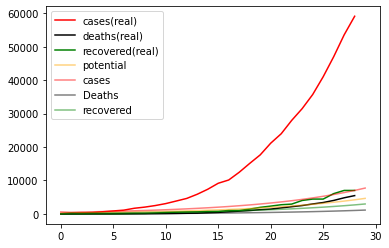

In [0]:
def forcast(seir, T):
    predict = seir.predict(60000000, potentials, 132, 2, 1, T)
    plt.plot(df_data[0:29]['cases'], label='cases(real)', color='red')
    plt.plot(df_data[0:29]['deaths'], label='deaths(real)', color='black')
    plt.plot(df_data[0:29]['recovered'], label='recovered(real)', color='green')
    plt.plot(predict['E'], label='potential', color='orange', alpha=0.5)
    plt.plot(predict['I'], label='cases', color='red', alpha=0.5)
    plt.plot(predict['D'], label='Deaths', color='black', alpha=0.5)
    plt.plot(predict['R'], label='recovered', color='green', alpha=0.5)
    plt.legend()
    plt.show()
forcast(seir, 30)

In [0]:
a = np.array([[2,3,4],[1,2,3]])
b = np.array([[1,1,1],[2,2,2]])


In [0]:
c = (((a-b)**2)**(1/2))


In [0]:
c.sum()/len(c)/4

1.0

In [0]:
c

array([[1., 2., 3.],
       [1., 0., 1.]])

In [0]:
(((obs - est) ** 2)**(1/2)).sum()/len(obs)

NameError: ignored

In [0]:
,x0=[0.155,0.03,0.001,1/5.2,1/12.39,0.0004]